# Conversion Test Results Analysis

This notebook visualizes and compares model performance across different conversion domains.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
TEST_DIR = Path('test_output')
RESULTS_DIR = TEST_DIR / 'results'  # Change to 'results_no_guide' for no-guide results
USE_NO_GUIDE = True  # Set to True to analyze no-guide results
USE_MATH_ONLY = False  # Set to True to analyze math-only results
COMPARE_MATH_ONLY = True  # Set to True to compare math-only vs regular results

if USE_MATH_ONLY:
    RESULTS_DIR = TEST_DIR / 'results_math_only'
elif USE_NO_GUIDE:
    RESULTS_DIR = TEST_DIR / 'results_no_guide'

MODELS = ['gpt-4o', 'qwen-coder', 'llama-4']

## Load Results from All Models

In [2]:
def load_all_results(results_dir, models, result_type='regular'):
    """Load all result files from model-specific directories.
    
    Args:
        results_dir: Directory containing model subdirectories
        models: List of model names
        result_type: 'regular', 'no_guide', or 'math_only' - used for domain name extraction
    """
    all_data = []
    
    for model in models:
        model_dir = results_dir / model
        if not model_dir.exists():
            print(f"Warning: {model_dir} does not exist, skipping...")
            continue
        
        # Find all converted TSV files
        result_files = list(model_dir.glob('*_converted.tsv'))
        
        for result_file in result_files:
            try:
                df = pd.read_csv(result_file, sep='\t')
                # Extract domain name from filename
                domain = result_file.stem.replace('_converted', '')
                # Remove suffixes based on result type
                if result_type == 'math_only':
                    domain = domain.replace('_math_only', '').replace('_no_guide', '')
                elif result_type == 'no_guide':
                    domain = domain.replace('_no_guide', '').replace('_math_only', '')
                else:
                    domain = domain.replace('_no_guide', '').replace('_math_only', '')
                
                df['model'] = model
                df['domain'] = domain
                df['result_type'] = result_type
                all_data.append(df)
                print(f"Loaded {len(df)} rows from {model}/{result_file.name} ({result_type})")
            except Exception as e:
                print(f"Error loading {result_file}: {e}")
    
    if not all_data:
        return None
    
    return pd.concat(all_data, ignore_index=True)

# Determine result type for domain name extraction
result_type = 'math_only' if USE_MATH_ONLY else ('no_guide' if USE_NO_GUIDE else 'regular')

# Load all results
df_all = load_all_results(RESULTS_DIR, MODELS, result_type=result_type)

if df_all is not None:
    print(f"\nTotal rows loaded: {len(df_all)}")
    print(f"Domains: {df_all['domain'].nunique()}")
    print(f"Models: {df_all['model'].unique()}")
    print(f"Result type: {result_type}")
    print(f"\nColumns: {list(df_all.columns)}")

Loaded 20 rows from gpt-4o/temperature_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/moles_to_particles_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/currency_no_guide_converted.tsv (no_guide)
Loaded 10 rows from gpt-4o/clothing_sizes_women_shoe_size_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/energy_no_guide_converted.tsv (no_guide)
Loaded 10 rows from gpt-4o/clothing_sizes_women_bra_size_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/cooking_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/timezone_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/speed_no_guide_converted.tsv (no_guide)
Loaded 20 rows from gpt-4o/density_no_guide_converted.tsv (no_guide)
Loaded 10 rows from gpt-4o/clothing_sizes_men_pant_size_no_guide_converted.tsv (no_guide)
Loaded 10 rows from gpt-4o/clothing_sizes_men_shoe_size_no_guide_converted.tsv (no_guide)
Loaded 10 rows from gpt-4o/clothing_sizes_women_pant_size_no_guide_conv

## Calculate Summary Statistics

In [3]:
def calculate_stats(df):
    """Calculate summary statistics for each domain-model combination."""
    stats = []
    
    for domain in df['domain'].unique():
        for model in df['model'].unique():
            subset = df[(df['domain'] == domain) & (df['model'] == model)]
            
            if len(subset) == 0:
                continue
            
            # Calculate metrics
            total = len(subset)
            answered = subset['raw_response'].notna().sum()
            valid = subset['model_answer'].notna().sum()
            
            # Loss statistics
            losses = pd.to_numeric(subset['loss'], errors='coerce').dropna()
            correct = (losses == 0).sum() if len(losses) > 0 else 0
            accuracy = (correct / len(losses) * 100) if len(losses) > 0 else 0
            
            stats.append({
                'domain': domain,
                'model': model,
                'total': total,
                'answered': answered,
                'answer_rate': (answered / total * 100) if total > 0 else 0,
                'valid_answers': len(losses),
                'correct': correct,
                'accuracy': accuracy,
                'avg_loss': losses.mean() if len(losses) > 0 else None,
                'median_loss': losses.median() if len(losses) > 0 else None
            })
    
    return pd.DataFrame(stats)

# Calculate statistics
if df_all is not None:
    df_stats = calculate_stats(df_all)
    print("Summary Statistics:")
    print(df_stats.to_string(index=False))

Summary Statistics:
                        domain      model  total  answered  answer_rate  valid_answers  correct   accuracy     avg_loss  median_loss
                   temperature     gpt-4o     20        20        100.0             20       18  90.000000     0.026179     0.000000
                   temperature qwen-coder     20        20        100.0             20       20 100.000000     0.000000     0.000000
                   temperature    llama-4     20        20        100.0             20       18  90.000000     0.052760     0.000000
            moles_to_particles     gpt-4o     20        20        100.0             20       14  70.000000   264.784578     0.000000
            moles_to_particles qwen-coder     20        20        100.0             20        4  20.000000    80.000000   100.000000
            moles_to_particles    llama-4     20        20        100.0             20        9  45.000000    52.490225    74.952242
                      currency     gpt-4o     20 

## Visualization 1: Accuracy by Domain and Model (Heatmap)

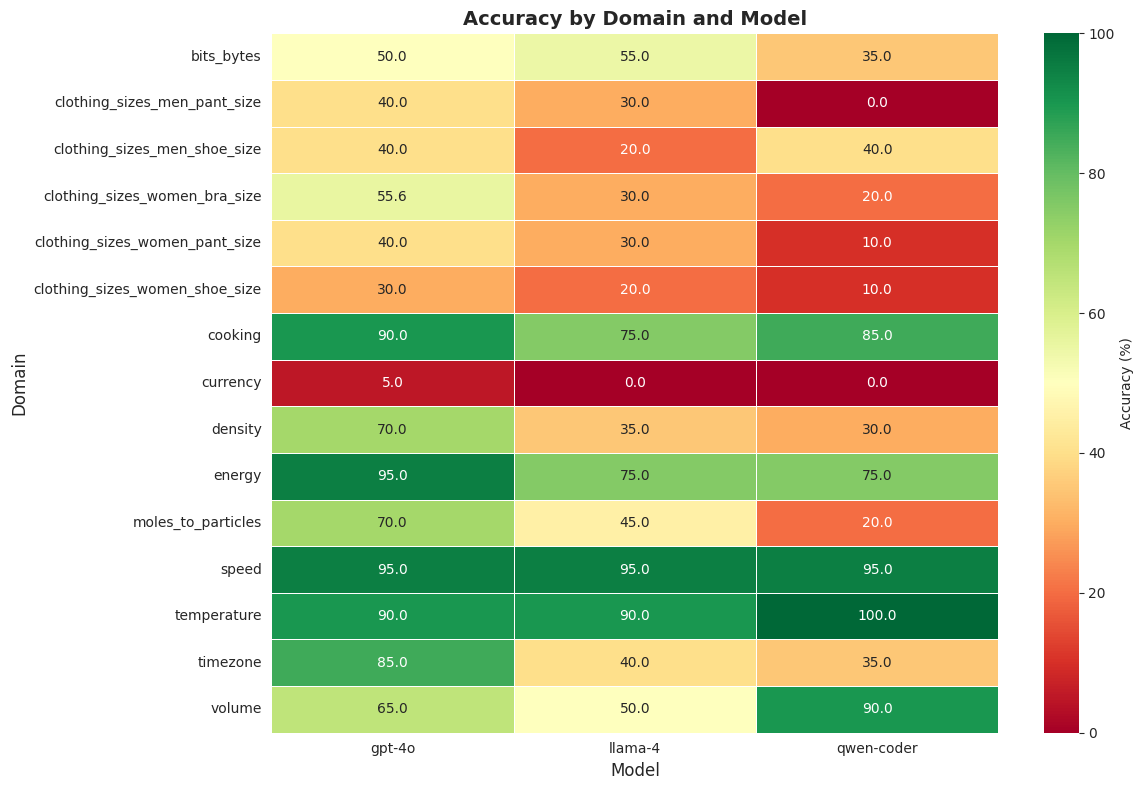

In [4]:
if df_all is not None and 'df_stats' in locals():
    # Create pivot table for heatmap
    pivot_accuracy = df_stats.pivot(index='domain', columns='model', values='accuracy')
    
    # Create heatmap
    plt.figure(figsize=(12, max(8, len(pivot_accuracy) * 0.5)))
    sns.heatmap(pivot_accuracy, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100,
                cbar_kws={'label': 'Accuracy (%)'}, linewidths=0.5)
    plt.title('Accuracy by Domain and Model', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Domain', fontsize=12)
    plt.tight_layout()
    plt.show()

## Visualization 2: Accuracy Comparison (Bar Chart)

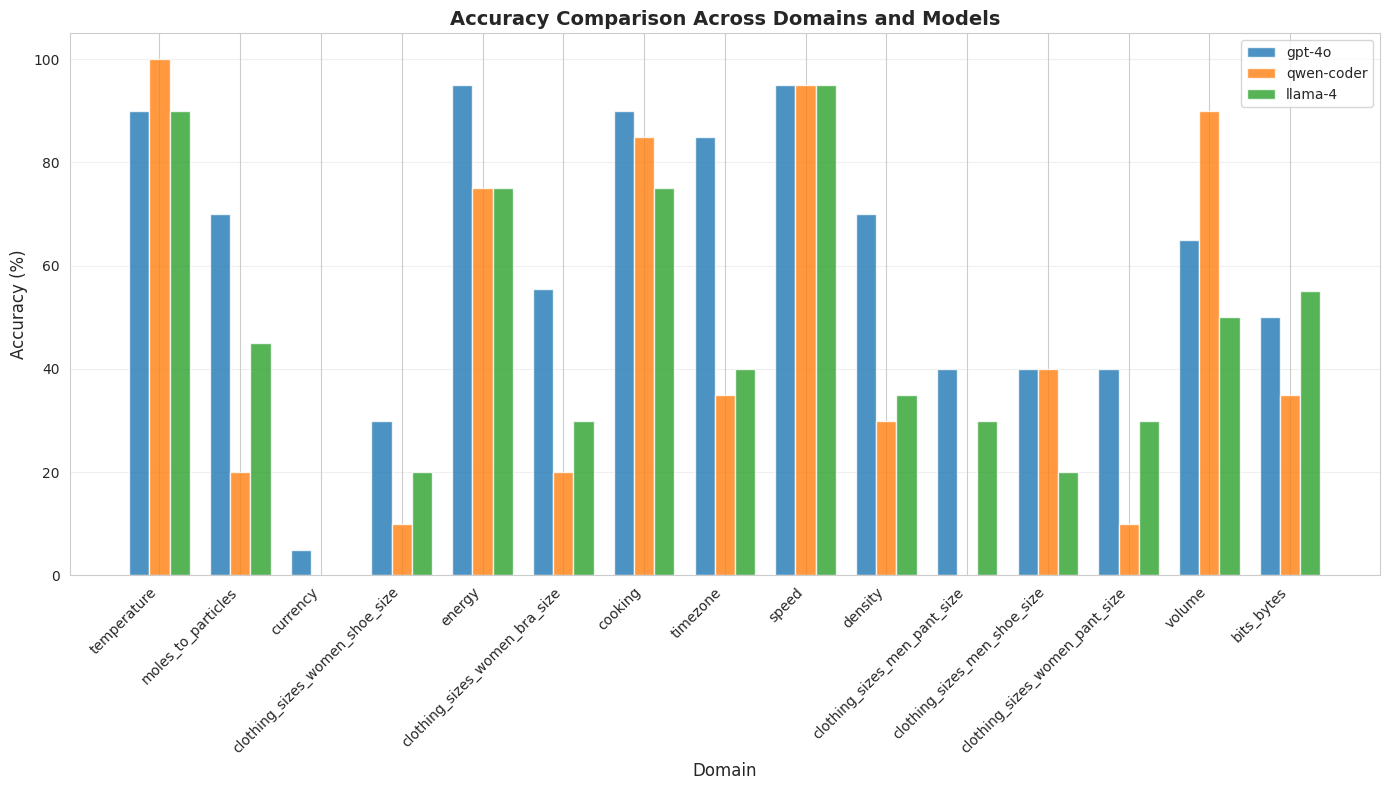

In [5]:
if df_all is not None and 'df_stats' in locals():
    # Group by domain and model
    fig, ax = plt.subplots(figsize=(14, 8))
    
    domains = df_stats['domain'].unique()
    x = np.arange(len(domains))
    width = 0.25
    
    for i, model in enumerate(MODELS):
        model_data = df_stats[df_stats['model'] == model]
        accuracies = [model_data[model_data['domain'] == d]['accuracy'].values[0] 
                     if len(model_data[model_data['domain'] == d]) > 0 else 0 
                     for d in domains]
        ax.bar(x + i*width, accuracies, width, label=model, alpha=0.8)
    
    ax.set_xlabel('Domain', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Accuracy Comparison Across Domains and Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(domains, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Visualization 3: Average Loss by Domain and Model

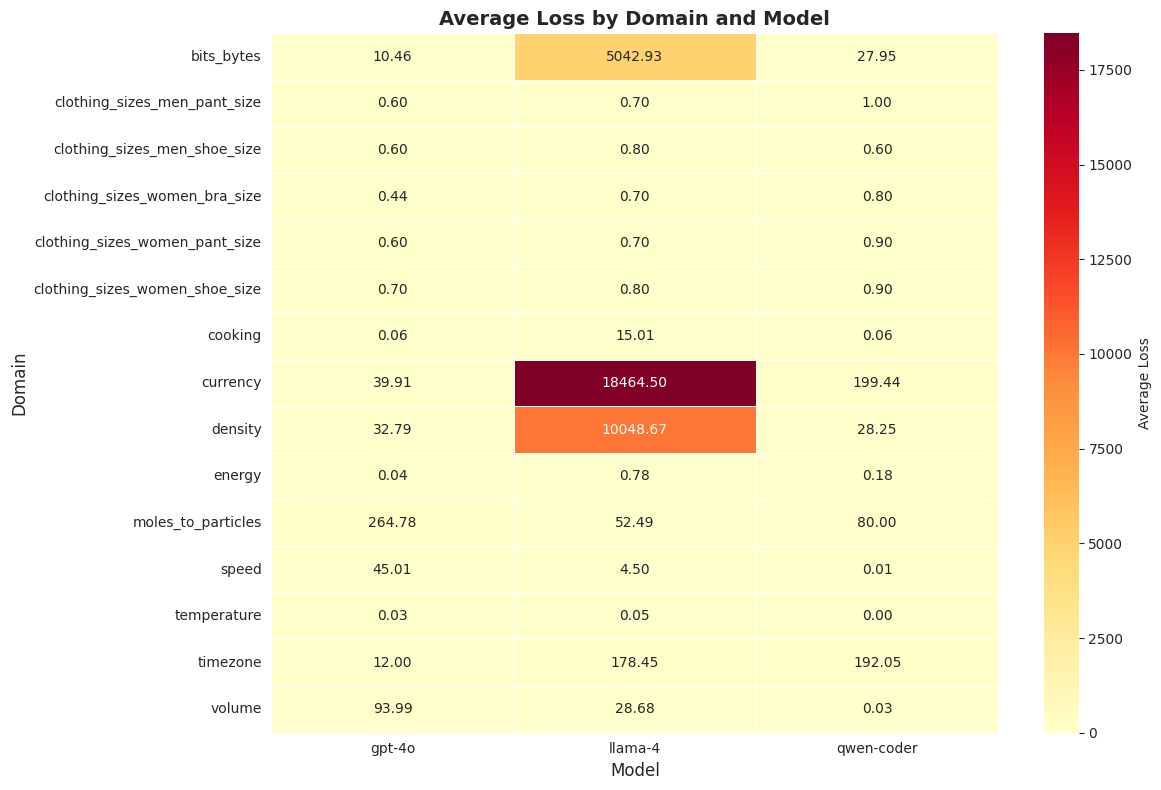

In [6]:
if df_all is not None and 'df_stats' in locals():
    # Create pivot table for average loss
    pivot_loss = df_stats.pivot(index='domain', columns='model', values='avg_loss')
    
    # Create heatmap
    plt.figure(figsize=(12, max(8, len(pivot_loss) * 0.5)))
    sns.heatmap(pivot_loss, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Average Loss'}, linewidths=0.5)
    plt.title('Average Loss by Domain and Model', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Domain', fontsize=12)
    plt.tight_layout()
    plt.show()

## Visualization 4: Overall Model Performance

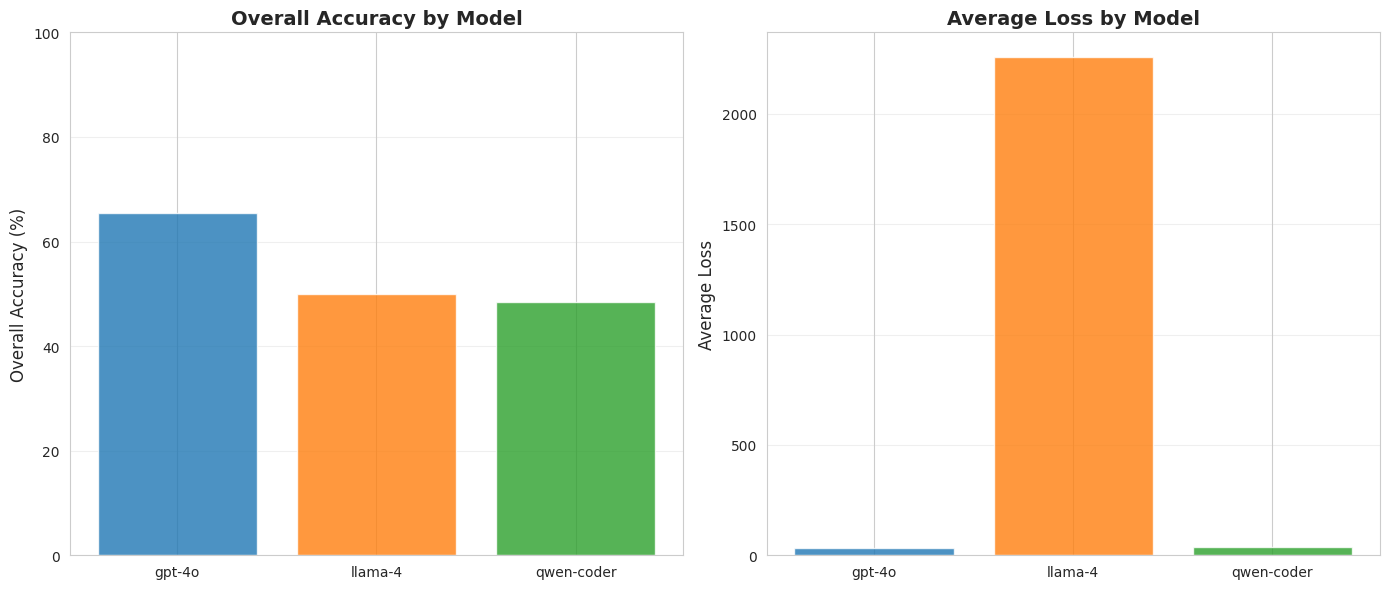


Overall Model Performance:
     model  overall_accuracy    avg_loss  total  correct
    gpt-4o         65.461847   33.467577    250      163
   llama-4         50.000000 2255.983831    250      125
qwen-coder         48.400000   35.477322    250      121


In [7]:
if df_all is not None and 'df_stats' in locals():
    # Aggregate by model
    model_summary = df_stats.groupby('model').agg({
        'total': 'sum',
        'correct': 'sum',
        'valid_answers': 'sum',
        'avg_loss': 'mean',
        'median_loss': 'mean'
    }).reset_index()
    
    model_summary['overall_accuracy'] = (model_summary['correct'] / model_summary['valid_answers'] * 100)
    
    # Create comparison chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy comparison
    ax1.bar(model_summary['model'], model_summary['overall_accuracy'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax1.set_title('Overall Accuracy by Model', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    # Average loss comparison
    ax2.bar(model_summary['model'], model_summary['avg_loss'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax2.set_ylabel('Average Loss', fontsize=12)
    ax2.set_title('Average Loss by Model', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nOverall Model Performance:")
    print(model_summary[['model', 'overall_accuracy', 'avg_loss', 'total', 'correct']].to_string(index=False))

## Visualization 5: Domain Difficulty Analysis

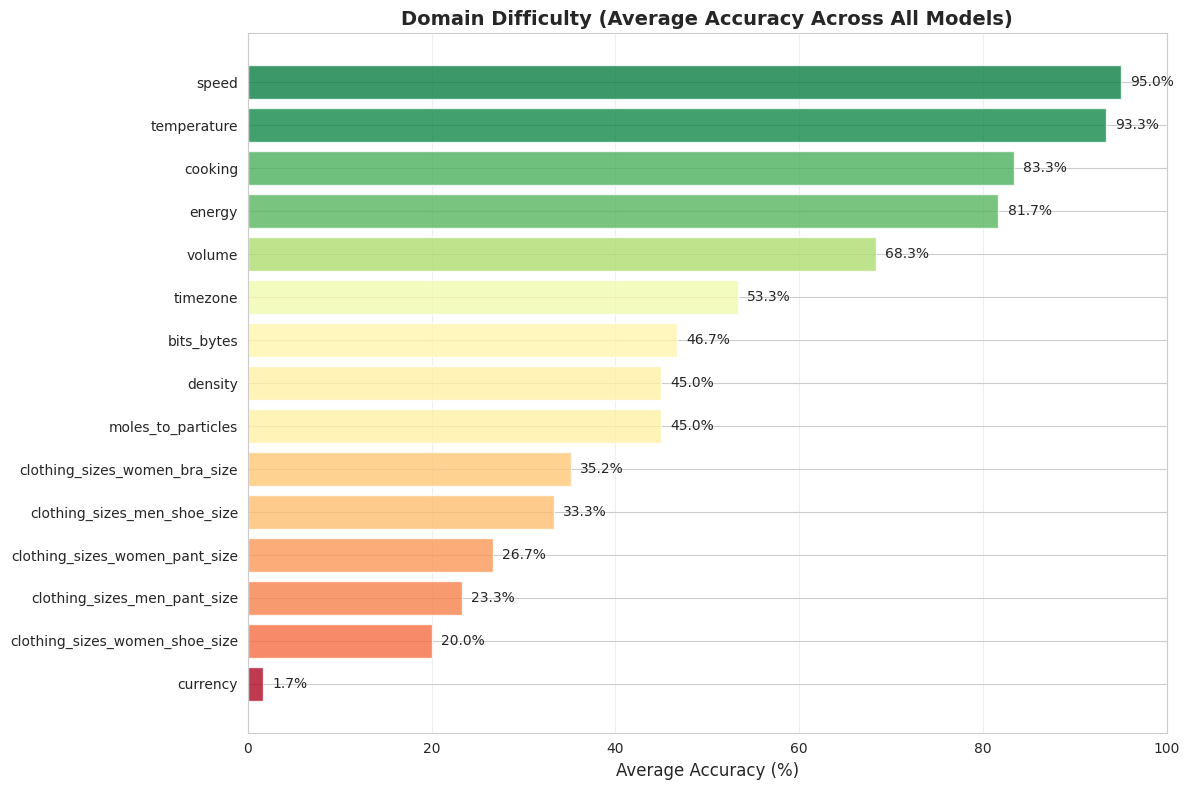

In [8]:
if df_all is not None and 'df_stats' in locals():
    # Calculate average accuracy per domain (across all models)
    domain_avg = df_stats.groupby('domain').agg({
        'accuracy': 'mean',
        'avg_loss': 'mean'
    }).reset_index()
    domain_avg = domain_avg.sort_values('accuracy', ascending=True)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.RdYlGn(domain_avg['accuracy'] / 100)
    ax.barh(domain_avg['domain'], domain_avg['accuracy'], color=colors, alpha=0.8)
    
    ax.set_xlabel('Average Accuracy (%)', fontsize=12)
    ax.set_title('Domain Difficulty (Average Accuracy Across All Models)', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (domain, acc) in enumerate(zip(domain_avg['domain'], domain_avg['accuracy'])):
        ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## Visualization 6: Compare With-Guide vs No-Guide Results

Loaded 10 rows from gpt-4o/clothing_sizes_women_bra_size_converted.tsv (regular)
Loaded 20 rows from gpt-4o/speed_converted.tsv (regular)
Loaded 20 rows from gpt-4o/bits_bytes_converted.tsv (regular)
Loaded 20 rows from gpt-4o/volume_converted.tsv (regular)
Loaded 10 rows from gpt-4o/clothing_sizes_women_shoe_size_converted.tsv (regular)
Loaded 20 rows from gpt-4o/currency_converted.tsv (regular)
Loaded 20 rows from gpt-4o/moles_to_particles_converted.tsv (regular)
Loaded 20 rows from gpt-4o/energy_converted.tsv (regular)
Loaded 10 rows from gpt-4o/clothing_sizes_men_pant_size_converted.tsv (regular)
Loaded 20 rows from gpt-4o/density_converted.tsv (regular)
Loaded 10 rows from gpt-4o/clothing_sizes_men_shoe_size_converted.tsv (regular)
Loaded 20 rows from gpt-4o/temperature_converted.tsv (regular)
Loaded 20 rows from gpt-4o/timezone_converted.tsv (regular)
Loaded 10 rows from gpt-4o/clothing_sizes_women_pant_size_converted.tsv (regular)
Loaded 20 rows from gpt-4o/cooking_converted.tsv

Loaded 20 rows from qwen-coder/energy_converted.tsv (regular)
Loaded 20 rows from llama-4/temperature_converted.tsv (regular)
Loaded 20 rows from llama-4/currency_converted.tsv (regular)
Loaded 20 rows from llama-4/volume_converted.tsv (regular)
Loaded 20 rows from llama-4/moles_to_particles_converted.tsv (regular)
Loaded 20 rows from llama-4/density_converted.tsv (regular)
Loaded 20 rows from llama-4/energy_converted.tsv (regular)
Loaded 10 rows from llama-4/clothing_sizes_women_shoe_size_converted.tsv (regular)
Loaded 20 rows from llama-4/timezone_converted.tsv (regular)
Loaded 10 rows from llama-4/clothing_sizes_women_bra_size_converted.tsv (regular)
Loaded 20 rows from llama-4/cooking_converted.tsv (regular)
Loaded 20 rows from llama-4/bits_bytes_converted.tsv (regular)
Loaded 10 rows from llama-4/clothing_sizes_men_pant_size_converted.tsv (regular)
Loaded 20 rows from llama-4/speed_converted.tsv (regular)
Loaded 10 rows from llama-4/clothing_sizes_men_shoe_size_converted.tsv (regu

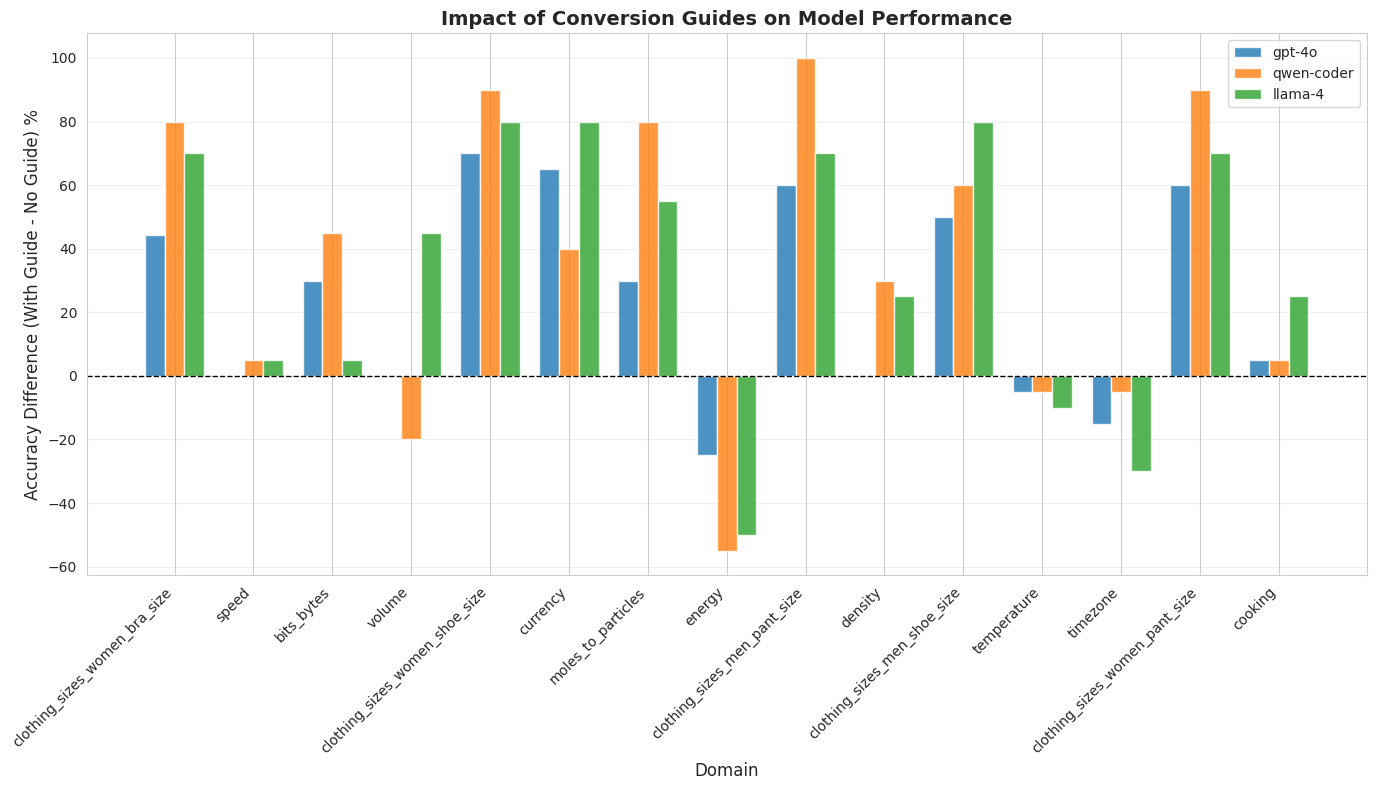


Guide Impact Summary:
                        domain      model  accuracy_with_guide  accuracy_no_guide  accuracy_diff
 clothing_sizes_women_bra_size     gpt-4o                100.0          55.555556      44.444444
 clothing_sizes_women_bra_size qwen-coder                100.0          20.000000      80.000000
 clothing_sizes_women_bra_size    llama-4                100.0          30.000000      70.000000
                         speed     gpt-4o                 95.0          95.000000       0.000000
                         speed qwen-coder                100.0          95.000000       5.000000
                         speed    llama-4                100.0          95.000000       5.000000
                    bits_bytes     gpt-4o                 80.0          50.000000      30.000000
                    bits_bytes qwen-coder                 80.0          35.000000      45.000000
                    bits_bytes    llama-4                 60.0          55.000000       5.000000
       

In [9]:
# Load both with-guide and no-guide results for comparison
results_with_guide = TEST_DIR / 'results'
results_no_guide = TEST_DIR / 'results_no_guide'

if results_with_guide.exists() and results_no_guide.exists():
    df_with_guide = load_all_results(results_with_guide, MODELS, result_type='regular')
    df_no_guide = load_all_results(results_no_guide, MODELS, result_type='no_guide')
    
    if df_with_guide is not None and df_no_guide is not None:
        stats_with = calculate_stats(df_with_guide)
        stats_no = calculate_stats(df_no_guide)
        
        # Merge for comparison
        comparison = stats_with.merge(
            stats_no,
            on=['domain', 'model'],
            suffixes=('_with_guide', '_no_guide')
        )
        
        # Calculate difference
        comparison['accuracy_diff'] = comparison['accuracy_with_guide'] - comparison['accuracy_no_guide']
        
        # Visualize
        fig, ax = plt.subplots(figsize=(14, 8))
        
        domains = comparison['domain'].unique()
        x = np.arange(len(domains))
        width = 0.25
        
        for i, model in enumerate(MODELS):
            model_data = comparison[comparison['model'] == model]
            diffs = [model_data[model_data['domain'] == d]['accuracy_diff'].values[0] 
                    if len(model_data[model_data['domain'] == d]) > 0 else 0 
                    for d in domains]
            ax.bar(x + i*width, diffs, width, label=model, alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Domain', fontsize=12)
        ax.set_ylabel('Accuracy Difference (With Guide - No Guide) %', fontsize=12)
        ax.set_title('Impact of Conversion Guides on Model Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(domains, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nGuide Impact Summary:")
        print(comparison[['domain', 'model', 'accuracy_with_guide', 'accuracy_no_guide', 'accuracy_diff']].to_string(index=False))
else:
    print("Both results directories not found. Skipping comparison.")

## Visualization 7: Detailed Comparison Table

## Visualization 8: Compare Math-Only vs Regular/No-Guide Results

Loaded 20 rows from gpt-4o/moles_to_particles_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/cooking_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/volume_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/density_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/energy_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/bits_bytes_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/currency_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/temperature_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/speed_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/timezone_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/bits_bytes_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/temperature_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/density_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/energy_math

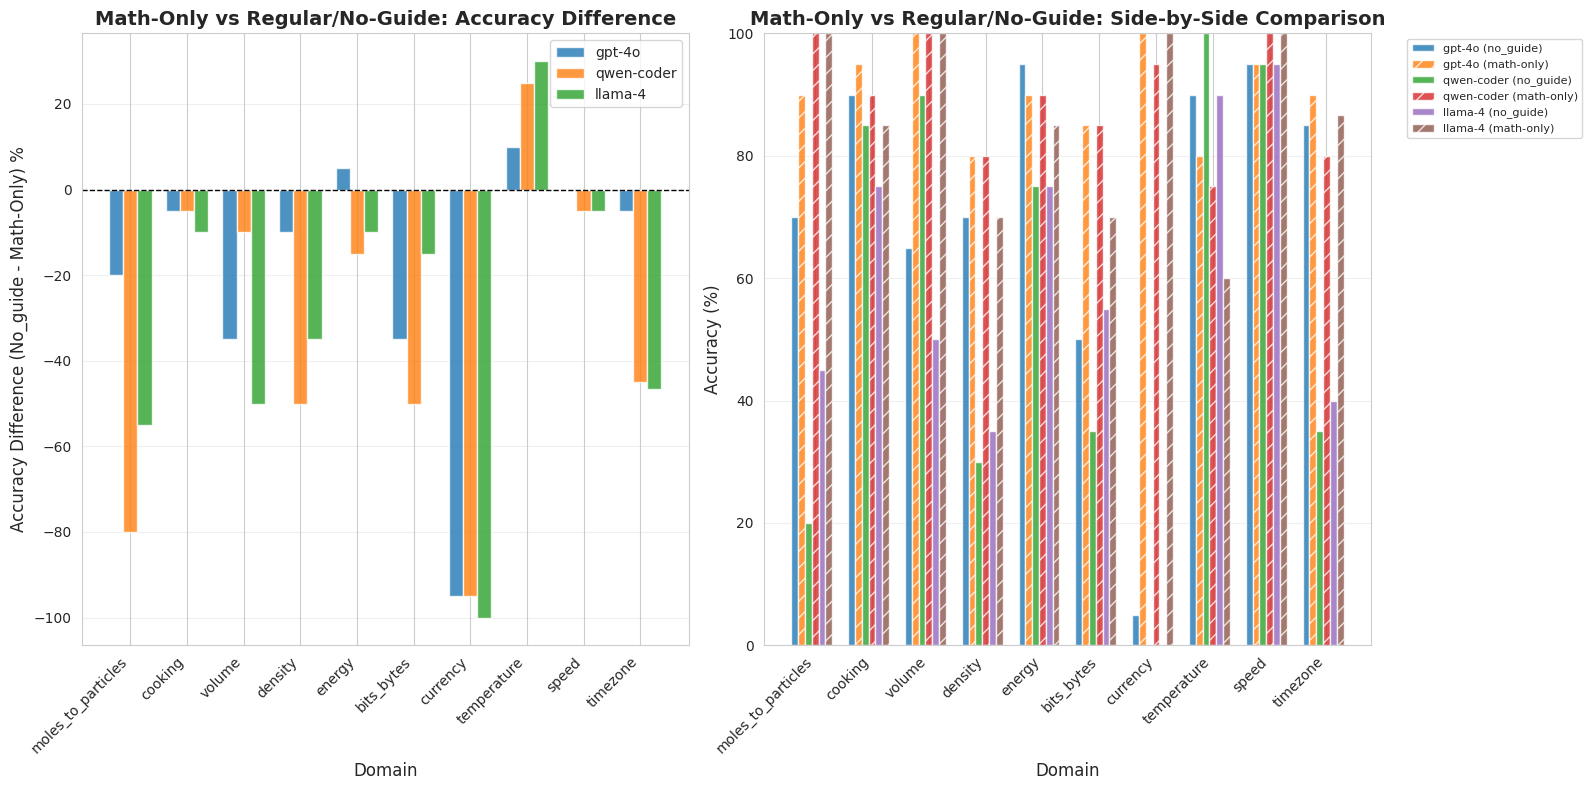


Math-Only vs Baseline Comparison Summary:
            domain      model  accuracy_no_guide  accuracy_math_only  accuracy_diff
moles_to_particles     gpt-4o               70.0           90.000000     -20.000000
moles_to_particles qwen-coder               20.0          100.000000     -80.000000
moles_to_particles    llama-4               45.0          100.000000     -55.000000
           cooking     gpt-4o               90.0           95.000000      -5.000000
           cooking qwen-coder               85.0           90.000000      -5.000000
           cooking    llama-4               75.0           85.000000     -10.000000
            volume     gpt-4o               65.0          100.000000     -35.000000
            volume qwen-coder               90.0          100.000000     -10.000000
            volume    llama-4               50.0          100.000000     -50.000000
           density     gpt-4o               70.0           80.000000     -10.000000
           density qwen-coder    

In [10]:
# Compare math-only results with regular or no-guide results
if COMPARE_MATH_ONLY:
    results_math_only = TEST_DIR / 'results_math_only'
    
    # Choose baseline: prefer no-guide if available, otherwise regular
    if (TEST_DIR / 'results_no_guide').exists():
        results_baseline = TEST_DIR / 'results_no_guide'
        baseline_type = 'no_guide'
    elif (TEST_DIR / 'results').exists():
        results_baseline = TEST_DIR / 'results'
        baseline_type = 'regular'
    else:
        results_baseline = None
        baseline_type = None
    
    if results_math_only.exists() and results_baseline is not None:
        df_math_only = load_all_results(results_math_only, MODELS, result_type='math_only')
        df_baseline = load_all_results(results_baseline, MODELS, result_type=baseline_type)
        
        if df_math_only is not None and df_baseline is not None:
            stats_math = calculate_stats(df_math_only)
            stats_base = calculate_stats(df_baseline)
            
            # Merge for comparison
            comparison_math = stats_math.merge(
                stats_base,
                on=['domain', 'model'],
                suffixes=('_math_only', f'_{baseline_type}')
            )
            
            # Calculate difference
            comparison_math['accuracy_diff'] = comparison_math[f'accuracy_{baseline_type}'] - comparison_math['accuracy_math_only']
            
            # Filter to domains that exist in both (math_only only works for certain domains)
            comparison_math = comparison_math.dropna(subset=['accuracy_math_only', f'accuracy_{baseline_type}'])
            
            if len(comparison_math) > 0:
                # Visualize accuracy difference
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                
                # Plot 1: Accuracy difference by domain and model
                domains = comparison_math['domain'].unique()
                x = np.arange(len(domains))
                width = 0.25
                
                for i, model in enumerate(MODELS):
                    model_data = comparison_math[comparison_math['model'] == model]
                    diffs = [model_data[model_data['domain'] == d]['accuracy_diff'].values[0] 
                            if len(model_data[model_data['domain'] == d]) > 0 else 0 
                            for d in domains]
                    ax1.bar(x + i*width, diffs, width, label=model, alpha=0.8)
                
                ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
                ax1.set_xlabel('Domain', fontsize=12)
                ax1.set_ylabel(f'Accuracy Difference ({baseline_type.capitalize()} - Math-Only) %', fontsize=12)
                ax1.set_title('Math-Only vs Regular/No-Guide: Accuracy Difference', fontsize=14, fontweight='bold')
                ax1.set_xticks(x + width)
                ax1.set_xticklabels(domains, rotation=45, ha='right')
                ax1.legend()
                ax1.grid(axis='y', alpha=0.3)
                
                # Plot 2: Side-by-side comparison
                pivot_math = comparison_math.pivot_table(
                    index='domain',
                    columns='model',
                    values=[f'accuracy_{baseline_type}', 'accuracy_math_only'],
                    aggfunc='mean'
                )
                
                # Create grouped bar chart
                domains_list = comparison_math['domain'].unique()
                x2 = np.arange(len(domains_list))
                width2 = 0.12
                
                for i, model in enumerate(MODELS):
                    baseline_acc = [comparison_math[(comparison_math['domain'] == d) & 
                                                   (comparison_math['model'] == model)][f'accuracy_{baseline_type}'].values[0]
                                   if len(comparison_math[(comparison_math['domain'] == d) & 
                                                         (comparison_math['model'] == model)]) > 0 else 0
                                   for d in domains_list]
                    math_acc = [comparison_math[(comparison_math['domain'] == d) & 
                                               (comparison_math['model'] == model)]['accuracy_math_only'].values[0]
                               if len(comparison_math[(comparison_math['domain'] == d) & 
                                                     (comparison_math['model'] == model)]) > 0 else 0
                               for d in domains_list]
                    
                    ax2.bar(x2 + i*width2*2, baseline_acc, width2, label=f'{model} ({baseline_type})', alpha=0.8)
                    ax2.bar(x2 + i*width2*2 + width2, math_acc, width2, label=f'{model} (math-only)', alpha=0.8, hatch='//')
                
                ax2.set_xlabel('Domain', fontsize=12)
                ax2.set_ylabel('Accuracy (%)', fontsize=12)
                ax2.set_title('Math-Only vs Regular/No-Guide: Side-by-Side Comparison', fontsize=14, fontweight='bold')
                ax2.set_xticks(x2 + width2 * len(MODELS))
                ax2.set_xticklabels(domains_list, rotation=45, ha='right')
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
                ax2.grid(axis='y', alpha=0.3)
                ax2.set_ylim(0, 100)
                
                plt.tight_layout()
                plt.show()
                
                print("\nMath-Only vs Baseline Comparison Summary:")
                print(comparison_math[['domain', 'model', f'accuracy_{baseline_type}', 'accuracy_math_only', 'accuracy_diff']].to_string(index=False))
                
                # Overall summary
                print("\n\nOverall Summary:")
                overall_math = stats_math.groupby('model')['accuracy'].mean()
                overall_base = stats_base.groupby('model')['accuracy'].mean()
                summary_df = pd.DataFrame({
                    'baseline_accuracy': overall_base,
                    'math_only_accuracy': overall_math,
                    'difference': overall_base - overall_math
                })
                print(summary_df.to_string())
            else:
                print("No overlapping domains found between math-only and baseline results.")
        else:
            print("Could not load both math-only and baseline results.")
    else:
        print(f"Math-only results directory not found: {results_math_only}")
        if results_baseline is None:
            print("Baseline results directory not found.")
else:
    print("COMPARE_MATH_ONLY is set to False. Set to True to enable math-only comparison.")

## Visualization 9: Math-Only Performance by Conversion Type

Loaded 20 rows from gpt-4o/moles_to_particles_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/cooking_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/volume_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/density_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/energy_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/bits_bytes_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/currency_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/temperature_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/speed_math_only_converted.tsv (math_only)
Loaded 20 rows from gpt-4o/timezone_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/bits_bytes_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/temperature_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/density_math_only_converted.tsv (math_only)
Loaded 20 rows from qwen-coder/energy_math

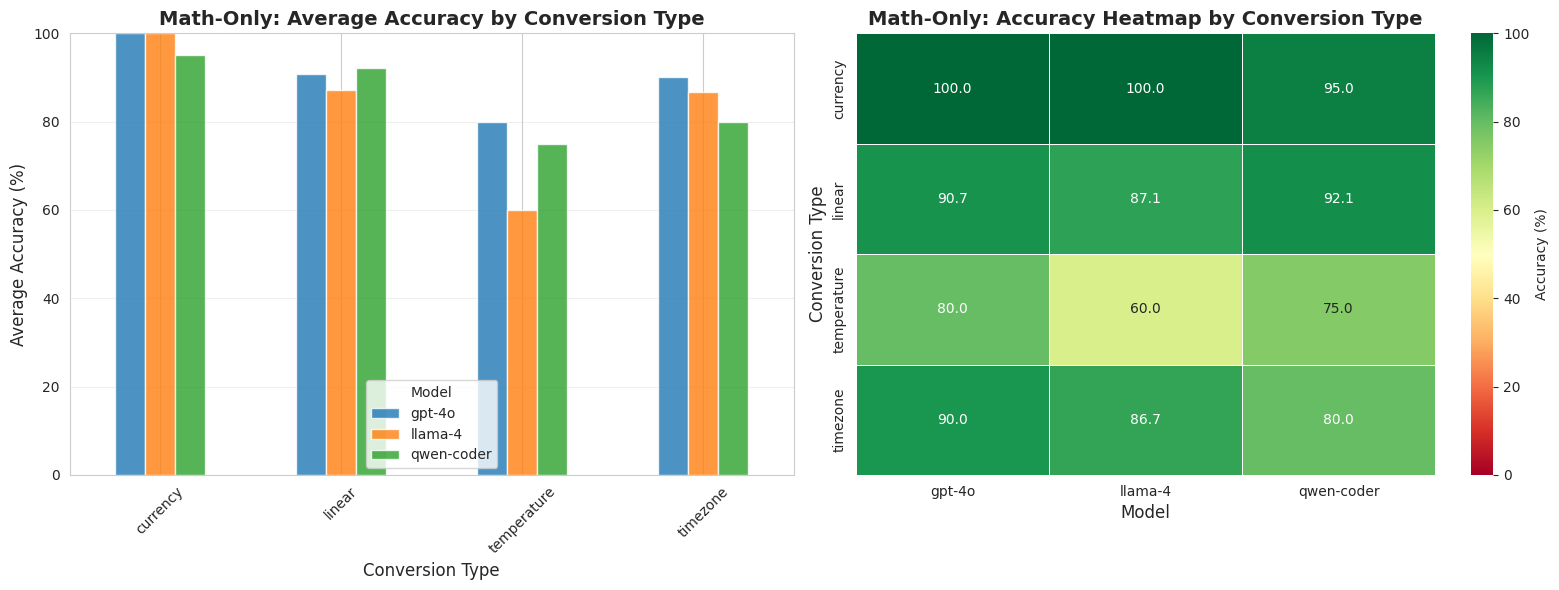


Math-Only Performance by Conversion Type:
                              accuracy       avg_loss  correct  total
conversion_type model                                                
currency        gpt-4o      100.000000       0.000000       20     20
                llama-4     100.000000       0.000000       20     20
                qwen-coder   95.000000       0.007244       19     20
linear          gpt-4o       90.714286       0.020375      127    140
                llama-4      87.142857  714288.723779      122    140
                qwen-coder   92.142857     714.950887      129    140
temperature     gpt-4o       80.000000       0.803066       16     20
                llama-4      60.000000       6.501599       12     20
                qwen-coder   75.000000       9.422135       15     20
timezone        gpt-4o       90.000000       0.100000        9     20
                llama-4      86.666667      48.800000       13     20
                qwen-coder   80.000000      96.

In [ ]:
# Analyze math-only results by conversion type
if COMPARE_MATH_ONLY and (TEST_DIR / 'results_math_only').exists():
    df_math_only = load_all_results(TEST_DIR / 'results_math_only', MODELS, result_type='math_only')
    
    if df_math_only is not None:
        stats_math = calculate_stats(df_math_only)
        
        # Categorize domains by conversion type
        # this lumps all the linear conversions together; change this if you want to see the individual ones
        conversion_types = {
            'linear': ['volume', 'speed', 'density', 'bits_bytes', 'energy', 'cooking', 'moles_to_particles'],
            'currency': ['currency'],
            'temperature': ['temperature'],
            'timezone': ['timezone']
        }
        
        # Add conversion type to stats
        stats_math['conversion_type'] = stats_math['domain'].apply(
            lambda d: next((k for k, v in conversion_types.items() if d in v), 'other')
        )
        
        # Visualize by conversion type
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Average accuracy by conversion type
        type_accuracy = stats_math.groupby(['conversion_type', 'model'])['accuracy'].mean().unstack()
        type_accuracy.plot(kind='bar', ax=ax1, alpha=0.8)
        ax1.set_xlabel('Conversion Type', fontsize=12)
        ax1.set_ylabel('Average Accuracy (%)', fontsize=12)
        ax1.set_title('Math-Only: Average Accuracy by Conversion Type', fontsize=14, fontweight='bold')
        ax1.legend(title='Model')
        ax1.set_ylim(0, 100)
        ax1.grid(axis='y', alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Accuracy heatmap by conversion type and model
        pivot_type = stats_math.pivot_table(
            index='conversion_type',
            columns='model',
            values='accuracy',
            aggfunc='mean'
        )
        
        sns.heatmap(pivot_type, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100,
                    cbar_kws={'label': 'Accuracy (%)'}, linewidths=0.5, ax=ax2)
        ax2.set_title('Math-Only: Accuracy Heatmap by Conversion Type', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Model', fontsize=12)
        ax2.set_ylabel('Conversion Type', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        print("\nMath-Only Performance by Conversion Type:")
        print(stats_math.groupby(['conversion_type', 'model']).agg({
            'accuracy': 'mean',
            'avg_loss': 'mean',
            'correct': 'sum',
            'total': 'sum'
        }).to_string())

In [ ]:
if df_all is not None and 'df_stats' in locals():
    # Create detailed comparison table
    comparison = df_stats.pivot_table(
        index='domain',
        columns='model',
        values=['accuracy', 'avg_loss', 'correct', 'valid_answers'],
        aggfunc='first'
    )
    
    # Flatten column names
    comparison.columns = ['_'.join(col).strip() for col in comparison.columns.values]
    
    result_type_str = 'math_only' if USE_MATH_ONLY else ('no_guide' if USE_NO_GUIDE else 'with_guide')
    print(f"Detailed Comparison Table ({result_type_str}):")
    print("=" * 100)
    print(comparison.to_string())
    
    # Save to CSV
    # output_file = TEST_DIR / f"model_comparison_{result_type_str}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    # comparison.to_csv(output_file)
    # print(f"\nComparison table saved to: {output_file}")

Detailed Comparison Table (no_guide):
                                accuracy_gpt-4o  accuracy_llama-4  accuracy_qwen-coder  avg_loss_gpt-4o  avg_loss_llama-4  avg_loss_qwen-coder  correct_gpt-4o  correct_llama-4  correct_qwen-coder  valid_answers_gpt-4o  valid_answers_llama-4  valid_answers_qwen-coder
domain                                                                                                                                                                                                                                                                    
bits_bytes                            50.000000              55.0                 35.0        10.461466       5042.927728            27.948972              10               11                   7                    20                     20                        20
clothing_sizes_men_pant_size          40.000000              30.0                  0.0         0.600000          0.700000             1.000000               4   